<a href="https://colab.research.google.com/github/elka97/GB_PyTorch/blob/main/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание

1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

# imports

In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from torchsummary import summary
from torch.nn.modules import activation

import datetime

# load data

In [2]:
train_data = datasets.CIFAR100(root='data/', train=True, download=True,)
valid_data = datasets.CIFAR100(root='data/', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data/
    Split: Train

In [4]:
valid_data

Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data/
    Split: Test

# constants

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_epochs=10
print_every = 300

img_size=32 
batch_size=128
num_classes=len(train_data.classes)

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

device, img_size, batch_size, num_classes, num_epochs, print_every

('cuda', 32, 128, 100, 10, 300)

In [6]:
criterion = nn.CrossEntropyLoss()
lr_cnn = [1e-3, 1e-4]
lr_cnn

[0.001, 0.0001]

In [7]:
# for reproducibility
torch.manual_seed(13) 

# data pre-processing/loaders

In [8]:
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [9]:
def get_dataloaders(train_df, test_df, train_transformations, test_transformations):
  _train_ds = MyOwnCifar(train_df, train_transformations)
  _valid_ds = MyOwnCifar(test_df, test_transformations)

  _train_ldr = torch.utils.data.DataLoader(_train_ds,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2)
  _valid_ldr = torch.utils.data.DataLoader(_valid_ds,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=1)
  
  return _train_ldr, _valid_ldr

In [10]:
# means/std for normalization
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [11]:
# Data normalization only
train_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats,inplace=True)])
valid_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

In [12]:
train_loader, valid_loader = get_dataloaders(train_data, valid_data, train_transforms, valid_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32]) tensor(65)
rabbit


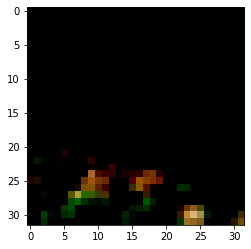

In [13]:
import matplotlib.pyplot as plt

for img, lbl in train_loader:
    print(img.shape, lbl[0])
    print(train_data.classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32]) tensor(49)
mountain


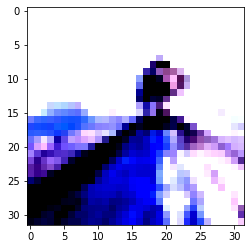

In [14]:
for img, lbl in valid_loader:
    print(img.shape, lbl[0])
    print(valid_data.classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

# utils

In [15]:
from time import time

def train_util(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch,
          # adam_optimizer_lr=0.001
          ):
  
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'({time() - iter_time:.3f} seconds)')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)

        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

# my CNN model

In [16]:
class MyCifar100Net(nn.Module): 

    def __init__(self, num_classes:int=1000):
      
        super(MyCifar100Net, self).__init__()
        self.layers = nn.Sequential(
            
          nn.BatchNorm2d(3),
          nn.Conv2d(in_channels=3, out_channels=30, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),   
          nn.Conv2d(in_channels=30, out_channels=60, kernel_size=3, padding=0),
          nn.ReLU(inplace=True),       
          nn.MaxPool2d(kernel_size=2),

          nn.BatchNorm2d(60),
          nn.Conv2d(in_channels=60, out_channels=120, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),  
          nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, padding=0), 
          nn.ReLU(inplace=True),      
          nn.MaxPool2d(kernel_size=2),

          nn.BatchNorm2d(120),
          nn.Conv2d(in_channels=120, out_channels=240, kernel_size=3, padding=1),
          nn.LeakyReLU(inplace=True, negative_slope=0.1),   
          nn.Conv2d(in_channels=240, out_channels=480, kernel_size=3, padding=0), 
          nn.LeakyReLU(inplace=True, negative_slope=0.1),       
          nn.MaxPool2d(kernel_size=2),        

          nn.BatchNorm2d(480),          
          nn.Flatten(),
          nn.Dropout(0.25), 
         
          nn.Linear(480*2*2, 1000),  
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),        

          nn.Linear(1000, num_classes))        
        
    def forward(self, x):
        return self.layers(x)  
       
net = MyCifar100Net(num_classes=num_classes).to(device)
print(net)
summary(net.to(device), input_size=(3, 32, 32))

MyCifar100Net(
  (layers): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(120, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): LeakyReLU(negative_slope=0.1, inplace=True)
    (15):

In [17]:
# train_loader, valid_loader = get_dataloaders(train_data, valid_data, train_transforms, valid_transforms)
optimizer = torch.optim.Adam(net.parameters(), lr=lr_cnn[0])

net, train_losses, val_losses = train_util(
    model=net,
    criterion=criterion,
    optimizer = optimizer,
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    print_every=print_every,
    num_epoch=num_epochs
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1]/[10]. Batch [300]/[391]. Train loss 3.717. Train acc 14.523. Val loss 3.046. Val acc 25.140. (15.860 seconds)


 10%|█         | 1/10 [00:18<02:49, 18.82s/it]

Epoch [2]/[10]. Batch [209]/[391]. Train loss 0.961. Train acc 30.943. Val loss 2.514. Val acc 35.490. (9.430 seconds)


 20%|██        | 2/10 [00:34<02:13, 16.74s/it]

Epoch [3]/[10]. Batch [118]/[391]. Train loss 0.288. Train acc 41.757. Val loss 2.221. Val acc 42.070. (6.367 seconds)


 30%|███       | 3/10 [00:49<01:51, 15.96s/it]

Epoch [4]/[10]. Batch [27]/[391]. Train loss 0.041. Train acc 50.463. Val loss 2.049. Val acc 45.640. (3.597 seconds)
Epoch [4]/[10]. Batch [327]/[391]. Train loss 0.359. Train acc 54.673. Val loss 2.007. Val acc 47.430. (11.974 seconds)


 40%|████      | 4/10 [01:06<01:39, 16.61s/it]

Epoch [5]/[10]. Batch [236]/[391]. Train loss 0.216. Train acc 53.959. Val loss 1.895. Val acc 49.750. (10.170 seconds)


 50%|█████     | 5/10 [01:21<01:20, 16.06s/it]

Epoch [6]/[10]. Batch [145]/[391]. Train loss 0.097. Train acc 59.871. Val loss 1.875. Val acc 51.050. (7.258 seconds)


 60%|██████    | 6/10 [01:37<01:04, 16.01s/it]

Epoch [7]/[10]. Batch [54]/[391]. Train loss 0.025. Train acc 66.319. Val loss 1.839. Val acc 52.460. (5.174 seconds)
Epoch [7]/[10]. Batch [354]/[391]. Train loss 0.103. Train acc 76.311. Val loss 2.116. Val acc 51.330. (12.279 seconds)


 70%|███████   | 7/10 [01:56<00:50, 16.87s/it]

Epoch [8]/[10]. Batch [263]/[391]. Train loss 0.100. Train acc 66.109. Val loss 1.890. Val acc 52.520. (10.966 seconds)


 80%|████████  | 8/10 [02:11<00:32, 16.28s/it]

Epoch [9]/[10]. Batch [172]/[391]. Train loss 0.050. Train acc 70.935. Val loss 1.928. Val acc 53.470. (8.093 seconds)


 90%|█████████ | 9/10 [02:26<00:15, 15.88s/it]

Epoch [10]/[10]. Batch [81]/[391]. Train loss 0.019. Train acc 74.566. Val loss 1.914. Val acc 54.020. (5.221 seconds)
Epoch [10]/[10]. Batch [381]/[391]. Train loss 0.038. Train acc 87.793. Val loss 2.657. Val acc 52.080. (11.955 seconds)


100%|██████████| 10/10 [02:43<00:00, 16.39s/it]


# дообучение ImageNet Resnet-50

In [18]:
from torchvision import models

def resnet_to_cifar100():
  _resnet = models.resnet50(pretrained=True)

  # Заморозим претренерованные слои, чтобы они не обучались.
  for param in list(_resnet.parameters())[:]:
      param.requires_grad = False

  # replace the last linear layer
  in_features = _resnet.fc.in_features
  _resnet.fc = nn.Linear(in_features=in_features, out_features=num_classes)
  _resnet = _resnet.to(device)

  # current trainable params
  _params_to_update = []
  for name, param in _resnet.named_parameters():
      if param.requires_grad == True:
          _params_to_update.append(param)

  return _resnet, _params_to_update

In [19]:
resnet, params_to_update = resnet_to_cifar100()

In [20]:
summary(resnet.to(device), input_size=(3, 224, 224)), len(params_to_update)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

(None, 2)

In [21]:
train_loader, valid_loader = get_dataloaders(train_data, valid_data, train_transforms, valid_transforms)

In [22]:
optimizer = torch.optim.Adam(params_to_update, lr=lr_cnn[0])

resnet, train_losses, val_losses = train_util(
    model=resnet,
    criterion=criterion, 
    optimizer=optimizer,   
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    print_every=print_every,
    num_epoch=num_epochs
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1]/[10]. Batch [300]/[391]. Train loss 3.566. Train acc 20.383. Val loss 3.220. Val acc 26.170. (13.922 seconds)


 10%|█         | 1/10 [00:17<02:35, 17.29s/it]

Epoch [2]/[10]. Batch [209]/[391]. Train loss 1.030. Train acc 29.912. Val loss 3.122. Val acc 27.920. (12.332 seconds)


 20%|██        | 2/10 [00:36<02:25, 18.23s/it]

Epoch [3]/[10]. Batch [118]/[391]. Train loss 0.360. Train acc 33.283. Val loss 3.093. Val acc 28.610. (7.448 seconds)


 30%|███       | 3/10 [00:53<02:04, 17.73s/it]

Epoch [4]/[10]. Batch [27]/[391]. Train loss 0.058. Train acc 37.471. Val loss 3.065. Val acc 29.730. (4.206 seconds)
Epoch [4]/[10]. Batch [327]/[391]. Train loss 0.552. Train acc 38.069. Val loss 3.059. Val acc 29.460. (13.373 seconds)


 40%|████      | 4/10 [01:13<01:51, 18.63s/it]

Epoch [5]/[10]. Batch [236]/[391]. Train loss 0.333. Train acc 37.169. Val loss 3.059. Val acc 29.570. (11.747 seconds)


 50%|█████     | 5/10 [01:30<01:30, 18.16s/it]

Epoch [6]/[10]. Batch [145]/[391]. Train loss 0.169. Train acc 38.960. Val loss 3.027. Val acc 30.540. (8.446 seconds)


 60%|██████    | 6/10 [01:48<01:11, 17.89s/it]

Epoch [7]/[10]. Batch [54]/[391]. Train loss 0.052. Train acc 41.638. Val loss 3.039. Val acc 30.420. (5.260 seconds)
Epoch [7]/[10]. Batch [354]/[391]. Train loss 0.294. Train acc 43.529. Val loss 3.051. Val acc 30.700. (13.428 seconds)


 70%|███████   | 7/10 [02:08<00:56, 18.68s/it]

Epoch [8]/[10]. Batch [263]/[391]. Train loss 0.207. Train acc 40.378. Val loss 3.019. Val acc 31.010. (12.612 seconds)


 80%|████████  | 8/10 [02:25<00:36, 18.24s/it]

Epoch [9]/[10]. Batch [172]/[391]. Train loss 0.120. Train acc 41.642. Val loss 3.083. Val acc 30.400. (9.345 seconds)


 90%|█████████ | 9/10 [02:43<00:18, 18.13s/it]

Epoch [10]/[10]. Batch [81]/[391]. Train loss 0.050. Train acc 43.615. Val loss 3.043. Val acc 30.700. (6.131 seconds)
Epoch [10]/[10]. Batch [381]/[391]. Train loss 0.200. Train acc 47.363. Val loss 3.051. Val acc 30.660. (13.464 seconds)


100%|██████████| 10/10 [03:03<00:00, 18.37s/it]


# дообучение ImageNet Resnet-50 с аугментацией данных

In [23]:
resnet_aug, params_to_update = resnet_to_cifar100()

In [24]:
# summary(resnet_aug.to(device), input_size=(3, 224, 224)), len(params_to_update)

In [25]:
len(params_to_update)

2

In [26]:
# Data transforms (normalization & data augmentation)
transforms_augmentation = transforms.Compose([
                         transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(),                          
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])

train_loader, valid_loader = get_dataloaders(train_data, valid_data, transforms_augmentation, valid_transforms)

optimizer = torch.optim.Adam(params_to_update, lr=lr_cnn[0])

resnet_aug, train_losses, val_losses = train_util(
    model=resnet_aug,
    criterion=criterion, 
    optimizer=optimizer,   
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    print_every=print_every,
    num_epoch=num_epochs
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1]/[10]. Batch [300]/[391]. Train loss 3.637. Train acc 18.914. Val loss 3.255. Val acc 25.790. (22.263 seconds)


 10%|█         | 1/10 [00:27<04:11, 27.91s/it]

Epoch [2]/[10]. Batch [209]/[391]. Train loss 1.109. Train acc 25.796. Val loss 3.097. Val acc 27.970. (16.544 seconds)


 20%|██        | 2/10 [00:55<03:43, 27.91s/it]

Epoch [3]/[10]. Batch [118]/[391]. Train loss 0.401. Train acc 28.277. Val loss 3.077. Val acc 28.550. (10.765 seconds)


 30%|███       | 3/10 [01:25<03:22, 28.89s/it]

Epoch [4]/[10]. Batch [27]/[391]. Train loss 0.068. Train acc 29.948. Val loss 3.034. Val acc 30.010. (7.872 seconds)
Epoch [4]/[10]. Batch [327]/[391]. Train loss 0.654. Train acc 30.036. Val loss 3.029. Val acc 30.100. (22.765 seconds)


 40%|████      | 4/10 [02:00<03:07, 31.17s/it]

Epoch [5]/[10]. Batch [236]/[391]. Train loss 0.386. Train acc 29.946. Val loss 2.967. Val acc 30.730. (18.309 seconds)


 50%|█████     | 5/10 [02:29<02:31, 30.37s/it]

Epoch [6]/[10]. Batch [145]/[391]. Train loss 0.200. Train acc 30.797. Val loss 2.950. Val acc 30.560. (12.586 seconds)


 60%|██████    | 6/10 [02:57<01:58, 29.58s/it]

Epoch [7]/[10]. Batch [54]/[391]. Train loss 0.066. Train acc 30.223. Val loss 2.963. Val acc 30.750. (6.758 seconds)
Epoch [7]/[10]. Batch [354]/[391]. Train loss 0.377. Train acc 31.864. Val loss 2.924. Val acc 32.080. (22.356 seconds)


 70%|███████   | 7/10 [03:29<01:30, 30.20s/it]

Epoch [8]/[10]. Batch [263]/[391]. Train loss 0.250. Train acc 31.779. Val loss 2.928. Val acc 31.760. (19.985 seconds)


 80%|████████  | 8/10 [03:57<00:58, 29.50s/it]

Epoch [9]/[10]. Batch [172]/[391]. Train loss 0.147. Train acc 32.140. Val loss 2.931. Val acc 31.970. (14.284 seconds)


 90%|█████████ | 9/10 [04:24<00:28, 28.97s/it]

Epoch [10]/[10]. Batch [81]/[391]. Train loss 0.063. Train acc 32.996. Val loss 2.906. Val acc 31.670. (8.645 seconds)
Epoch [10]/[10]. Batch [381]/[391]. Train loss 0.273. Train acc 33.374. Val loss 2.905. Val acc 31.670. (22.117 seconds)


100%|██████████| 10/10 [04:56<00:00, 29.63s/it]


качество на самописной модели выше, но с большой разницей на трейне и тесте.

улучшение в направлнии:
1. больше итераций (для всех моделей), 
2. более разнообразная аугментация (наверно)
3. постепенно замещать предпоследние слои в предобученной модели